In [124]:
import numpy as np
import pandas as pd
import numpy.random as random
sys.path.insert(0, '../../Libraries')
import JacksonsTSPackage as jts
from statsmodels.tsa.api import VAR

In [125]:
def mul_ten_and_mat(tensor, matrix):
    ten_shape = tensor.shape
    result = np.zeros((ten_shape[0], ten_shape[2]))
    for i in range(ten_shape[2]):
        result[:,i] = tensor[i,:,:].dot(matrix[:,i])
        #print(tensor[i,:,:], "DOT", matrix[:, i], "=", result[:,i])
    return result

N = 2000
A = np.array([
    [
        [0.8, 0, 0],
        [0, 0.8, 0],
        [0, 0, 0.8]
    ],
    [
        [0.8, 0, 0],
        [0, 0.8, 0],
        [0, 0, 0.8]
    ],
    [
        [0.8, 0, 0],
        [0, 0.8, 0],
        [0, 0, 0.8]
    ]
    ])

T = np.array([
        [1, -1, 1],
        [-1, 1, 1],
        [1, 1, -1]
    ])

tmp = np.array(
    [
        [0.1, 0.2, 0.3],
        [0.4, 0.5, 0.6],
        [0.7, 0.8, 0.9]
    ])

data_tensor = np.zeros((N, 3, 3))
data_tensor[0] = tmp
for i in range(1, N):
    data_tensor[i] = mul_ten_and_mat(A, data_tensor[i-1]) + random.uniform(-1, 1, (3, 3))# + T * i**2 / 500000
data_tensor.shape

(2000, 3, 3)

In [126]:
vectorized = pd.DataFrame(jts.tensor_to_vector(data_tensor))
vectorized

,0,1,2,3,4,5,6,7,8
0,0.100000,0.400000,0.700000,0.200000,0.500000,0.800000,0.300000,0.600000,0.900000
1,-0.833254,-0.447331,0.496483,-0.713291,1.072974,0.473144,-0.482191,-0.229826,0.810689
2,0.066439,-0.727043,0.983058,-0.133864,1.539784,0.122304,-0.844841,-0.688938,0.298255
3,0.277456,-0.804462,0.483097,0.862226,1.655062,-0.731535,-0.235633,-0.154610,0.399277
4,-0.372844,-1.370311,-0.477928,0.819656,1.396187,-1.450750,0.785244,0.370055,0.894779
...,...,...,...,...,...,...,...,...,...
1995,-1.138543,-1.158999,1.776323,-0.310669,-1.226511,-0.080623,-0.750065,0.307617,1.308106
1996,-1.741064,-0.581054,2.294011,0.403868,-1.223980,-0.397632,-0.524890,0.409037,1.371650
1997,-1.677868,-1.422766,2.296181,0.271608,-1.269410,0.526108,-0.332093,0.128435,1.637005
1998,-0.468598,-0.372804,1.116592,1.056128,-0.819553,0.466812,0.519986,-0.270431,1.389776


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

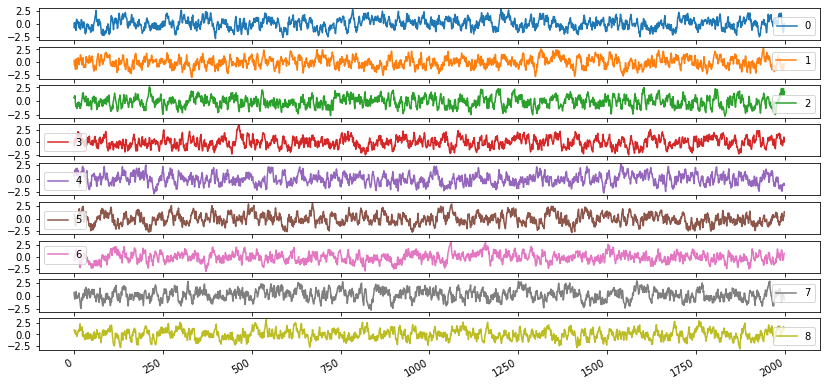

In [127]:
vectorized.plot(figsize = (14, 7), subplots = True)

In [128]:
N_train = 1800
N_test = N - N_train
print(f"N: {N}")
print(f"N_train: {N_train}")
print(f"N_test: {N_test}")

N: 2000
N_train: 1800
N_test: 200


In [129]:
train_tensor = jts.extract_train_tensor(data_tensor, N_train)
test_tensor = jts.extract_test_tensor(data_tensor, N_train, N_test)

In [130]:
from statsmodels.tsa.api import VAR
import scipy.fft as sfft

class LTAR():
    def __init__(self, train):

        if len(train.shape) != 3:
            raise ValueError(f"{len(train.shape)} is in invalid tensor norm. Only 3 norm tensors are valid with this class")
        
        self.train = train
        self.transformation = ""
        self.var_fits = []
        self.coefs = []
        self.B = [[]]
        self.matrix_shape = train.shape[1:3]
        self.p = -1

    def __apply_dct_to_tensor(self, tensor, type = 2):

        N = len(tensor)
        matrix_shape = tensor[0].shape
        dct_tensor = np.empty((N, matrix_shape[0], matrix_shape[1]))

        for i in range(N):
            for j in range(matrix_shape[0]):
                dct_tensor[i][j] = sfft.dct(tensor[i][j], type=type)

        return dct_tensor


    def __apply_inverse_dct_to_tensor(self, tensor, type = 2):

        N = len(tensor)
        matrix_shape = tensor[0].shape
        dct_tensor = np.empty((N, matrix_shape[0], matrix_shape[1]))

        for i in range(N):
            for j in range(matrix_shape[0]):
                dct_tensor[i][j] = sfft.idct(tensor[i][j], type=type)

        return dct_tensor
        

    def __apply_dwt_to_tensor(self, tensor, wavelet = 'haar'):

        N = len(tensor)
        matrix_shape = tensor[0].shape
        dwt_tensor = np.zeros((N, matrix_shape[0], matrix_shape[1]))

        for i in range(N):
            for j in range(matrix_shape[0]):
                tmp = pywt.dwt(tensor[i][j], wavelet)
                dwt_tensor[i][j] = np.append(tmp[0], tmp[1])
        return dwt_tensor


    def __apply_inverse_dwt_to_tensor(self, transformed_tensor, wavelet = 'haar'):

        N = len(transformed_tensor)
        matrix_shape = transformed_tensor[0].shape
        tensor = np.empty((N, matrix_shape[0], matrix_shape[1]))
        half_len = int(matrix_shape[0] / 2)

        for i in range(N):
            for j in range(matrix_shape[0]):
                tmp = (transformed_tensor[i][j][:half_len], transformed_tensor[i][j][half_len:])
                tensor[i][j] = pywt.idwt(tmp[0], tmp[1], wavelet)
        return tensor

    def __apply_trans(self, tensor):            

        if self.transformation == "dwt":
            result = self.__apply_dwt_to_tensor(tensor)
        elif self.transformation == "dct":
            result = self.__apply_dct_to_tensor(tensor)
        elif self.transformation == "dft":
            raise NotImplementedError()
        else:
            raise ValueError(f"{self.transformation} is not a valid transformation")

        return result

    def __apply_inverse_trans(self, trans_tensor):

        if self.transformation == "dwt":
            result = self.__apply_inverse_dwt_to_tensor(trans_tensor)
        elif self.transformation == "dct":
            result = self.__apply_inverse_dct_to_tensor(trans_tensor)
        elif self.transformation == "dft":
            raise NotImplementedError()
        else:
            raise ValueError(f"{self.transformation} is not a valid transformation")

        return result

    def __split_cols_into_model_sets(self, transformed_tensor, N):
        matrix_shape = transformed_tensor[0].shape
        model_sets = np.empty((matrix_shape[1], N, matrix_shape[0]))
        for i in range(matrix_shape[1]):
            for j in range(N):
                model_sets[i][j] = transformed_tensor[j][:,i]
        return model_sets

    def fit(self, p, transformation = "dct"):

        if p < 1:
            raise ValueError(f"{p} is an invalid lag")

        self.transformation = transformation
        l_train_tensor = self.__apply_trans(self.train)
        
        train_model_sets = self.__split_cols_into_model_sets(l_train_tensor, len(self.train))

        fits = []
        for i in range(self.matrix_shape[1]):
            train_df = pd.DataFrame(train_model_sets[i])
            model = VAR(train_df)
            fit = model.fit(p)
            fits.append(fit) 
        self.var_fits = fits

        coefs = np.empty((p, self.matrix_shape[1], self.matrix_shape[0], self.matrix_shape[0]))
        for i in range(self.matrix_shape[1]):
            curr_coefs = fits[i].coefs
            for j in range(p):
                coefs[j][i] = curr_coefs[j]
        print("BEFORE",coefs[0])
        for i in range(p):
            coefs[i] = self.__apply_inverse_trans(coefs[i])
        self.coefs = coefs
        print("AFTER",coefs[0])

    def forecast(self, interval):
        raise NotImplementedError()

ltar = LTAR(train_tensor)
ltar.fit(1)

BEFORE [[[ 7.90430809e-01  7.81476381e-04 -6.38842382e-03]
  [-8.83590045e-03  7.61247140e-01 -1.72164225e-02]
  [-3.18394841e-03 -1.46143295e-02  7.85924724e-01]]

 [[ 7.96497955e-01  9.91059244e-04 -9.66505221e-03]
  [ 5.27772229e-04  8.19349303e-01 -1.77880066e-03]
  [-6.65734057e-03 -1.27418179e-02  8.14120998e-01]]

 [[ 8.14536771e-01  4.59788079e-03  8.25269569e-03]
  [-2.26571193e-02  8.05674660e-01  7.26961538e-03]
  [-1.69368091e-04  4.89594241e-03  8.12903430e-01]]]
AFTER [[[ 0.13089932  0.13386794  0.13044814]
  [ 0.21541107  0.00426616 -0.22409517]
  [ 0.126238   -0.26250557  0.13467559]]

 [[ 0.13142491  0.13597134  0.13085272]
  [ 0.23631727  0.0006809  -0.23673428]
  [ 0.13089903 -0.27248322  0.13825552]]

 [[ 0.13845887  0.13300523  0.13580428]
  [ 0.23001366 -0.00619939 -0.23514282]
  [ 0.13686901 -0.27099604  0.13404234]]]
